In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

First, let's setup Spark in this environment, installing the corresponding dependencies by the following commands.

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=fa6c6b00ba67c89b7910f50610937d3aab6783183350c7df27a9148b777ca1cf
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:a

Setup the environment variable for java and JDK.

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Authenticate a Google Drive client to download the file which will be processed in this script.

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# authendicate and create a PyDrive client
auth.authenticate_user()
google_auth = GoogleAuth()
google_auth.credentials = GoogleCredentials.get_application_default()
google_drive = GoogleDrive(google_auth)

Import the libraries which will be used in the following operations.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Initialize the Spark context.

In [6]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
spark_context = pyspark.SparkContext(conf = conf)
spark = SparkSession.builder.getOrCreate()

Check the current version of Spark and get its API for web interface.

In [7]:
spark

Setting up the ngrok tunnel,setup the Spark UI as a separate website.

In [8]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!./ngrok authtoken 2RpDQonwjz6Oi3uyOqPzO55vwsq_MFGk1k3qTbFFMHWddyM9
!cat ~/.ngrok2/ngrok.yml
get_ipython().system_raw('./ngrok http 4050 &')

--2023-07-09 06:59:47--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 18.205.222.128, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  40.4MB/s    in 0.3s    

2023-07-09 06:59:48 (40.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
authtoken: 2RpDQonwjz6Oi3uyOqPzO55vwsq_MFGk1k3qTbFFMHWddyM9


Setup the proxy for the Spark website.

In [9]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


# Task 1
Load the datasets from files.

In [10]:
goalscorers = spark.read.option("header", "true").csv("/content/drive/MyDrive/COMP5434 Coding ASM 2/goalscorers.csv")
results = spark.read.option("header", "true").csv("/content/drive/MyDrive/COMP5434 Coding ASM 2/results.csv")

Check the schema of the two datasets.

In [11]:
goalscorers = goalscorers.withColumn("minute", goalscorers["minute"].cast("integer"))\
                          .withColumn("own_goal", goalscorers["own_goal"].cast("boolean"))\
                          .withColumn("penalty", goalscorers["penalty"].cast("boolean"))
goalscorers.printSchema()

root
 |-- date: string (nullable = true)
 |-- home_team: string (nullable = true)
 |-- away_team: string (nullable = true)
 |-- team: string (nullable = true)
 |-- scorer: string (nullable = true)
 |-- minute: integer (nullable = true)
 |-- own_goal: boolean (nullable = true)
 |-- penalty: boolean (nullable = true)



In [12]:
results.printSchema()

root
 |-- date: string (nullable = true)
 |-- home_team: string (nullable = true)
 |-- away_team: string (nullable = true)
 |-- home_score: string (nullable = true)
 |-- away_score: string (nullable = true)
 |-- tournament: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- neutral: string (nullable = true)



Using the `show()` function to get a formatted sample .

In [13]:
goalscorers.show()
results.show()

+----------+---------+---------+---------+--------------------+------+--------+-------+
|      date|home_team|away_team|     team|              scorer|minute|own_goal|penalty|
+----------+---------+---------+---------+--------------------+------+--------+-------+
|1916-07-02|    Chile|  Uruguay|  Uruguay|     José Piendibene|    44|   false|  false|
|1916-07-02|    Chile|  Uruguay|  Uruguay|    Isabelino Gradín|    55|   false|  false|
|1916-07-02|    Chile|  Uruguay|  Uruguay|    Isabelino Gradín|    70|   false|  false|
|1916-07-02|    Chile|  Uruguay|  Uruguay|     José Piendibene|    75|   false|  false|
|1916-07-06|Argentina|    Chile|Argentina|       Alberto Ohaco|     2|   false|  false|
|1916-07-06|Argentina|    Chile|    Chile|      Telésforo Báez|    44|   false|  false|
|1916-07-06|Argentina|    Chile|Argentina|  Juan Domingo Brown|    60|   false|   true|
|1916-07-06|Argentina|    Chile|Argentina|  Juan Domingo Brown|    62|   false|   true|
|1916-07-06|Argentina|    Chile|

Using the `count()` function to count number of goal entries.

In [14]:
goalscorers_count = goalscorers.count()
print("In total there are {0} goals".format(goalscorers_count))

In total there are 41008 goals


# Task 2

Based on the goal data goalscorers.csv, calculate and visualize the distribution of goals
according to the happening time.

In [15]:
temp1 = goalscorers\
          .groupBy("minute")\
          .count()\
          .sort(col("minute"))
temp1.take(20)

[Row(minute=None, count=258),
 Row(minute=1, count=188),
 Row(minute=2, count=323),
 Row(minute=3, count=296),
 Row(minute=4, count=324),
 Row(minute=5, count=365),
 Row(minute=6, count=326),
 Row(minute=7, count=374),
 Row(minute=8, count=403),
 Row(minute=9, count=325),
 Row(minute=10, count=407),
 Row(minute=11, count=396),
 Row(minute=12, count=395),
 Row(minute=13, count=354),
 Row(minute=14, count=384),
 Row(minute=15, count=435),
 Row(minute=16, count=385),
 Row(minute=17, count=361),
 Row(minute=18, count=426),
 Row(minute=19, count=389)]

In [16]:
temp1_pd = temp1.toPandas()
temp1_pd.head()

,minute,count
0,NaN,258
1,1.0,188
2,2.0,323
3,3.0,296
4,4.0,324


Draw a histogram to visualize the distribution of goals in each minute.

Text(0.5, 1.0, 'Number of goals in everyminute of the game')

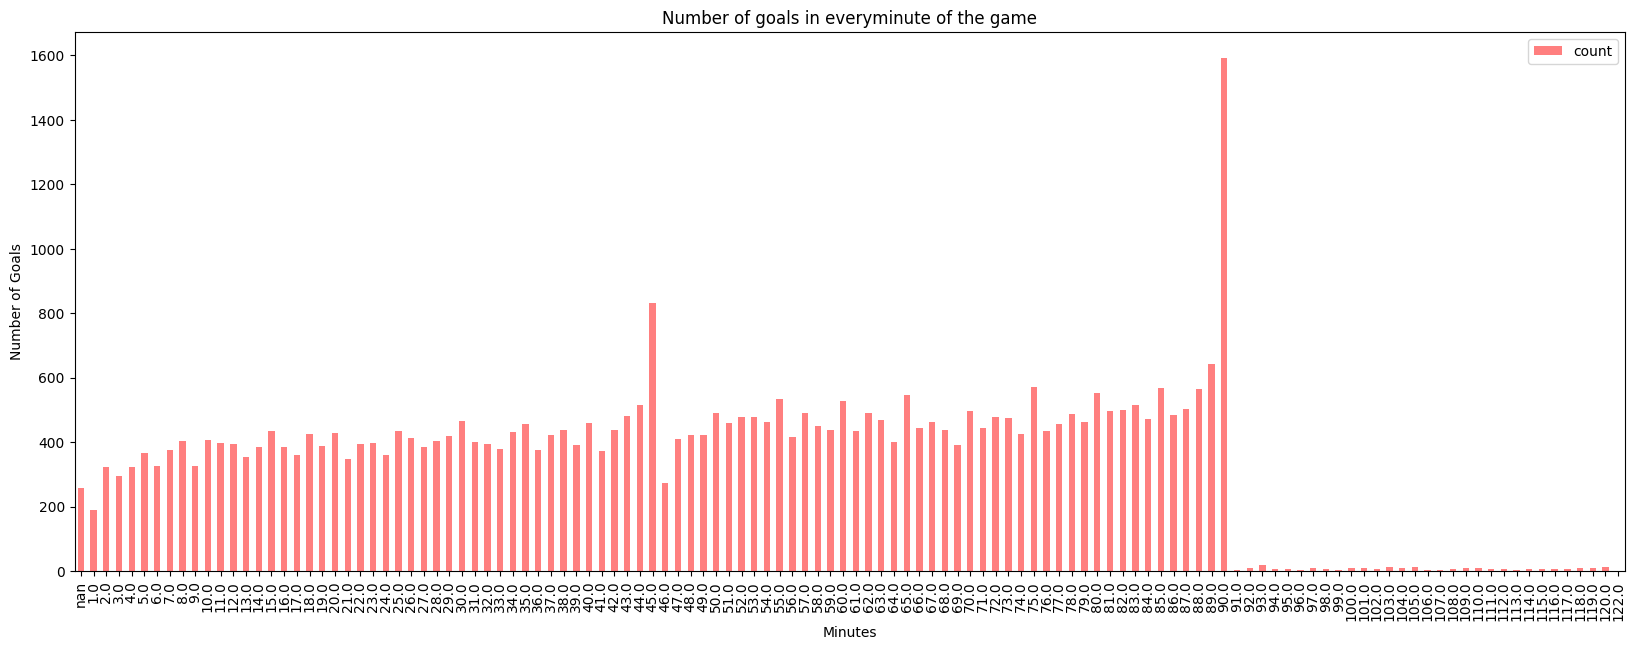

In [17]:
plot = temp1_pd.plot(
          kind="bar",
          x="minute",
          y="count",
          figsize=(20, 7),
          log=False,
          alpha=0.5,
          color="red"
)
plot.set_xlabel("Minutes")
plot.set_ylabel("Number of Goals")
plot.set_title("Number of goals in everyminute of the game")

# Task 3
Based on the goal data goalscorers.csv, calculate the number of goals of each player. You should output the top 10 players’ names as well as their goal numbers.



a. You should omit own goals, which cannot be taken into consideration when counting the number of goals for a specific player.

b. You should rank players according to the goal numbers.


In [24]:
top_scorer = goalscorers\
                    .groupBy("scorer","own_goal")\
                    .count()\
                    .filter(col("own_goal")==0)\
                    .filter(col("scorer")!='NA')\
                    .drop("own_goal")\
                    .sort(desc("count"))\
                    .withColumn(
                    "rank", dense_rank().over(Window.orderBy(desc("count"))))

print("Top 10 scoring players")
top_scorer.show(10)

Top 10 scoring players
+------------------+-----+----+
|            scorer|count|rank|
+------------------+-----+----+
| Cristiano Ronaldo|   91|   1|
|Robert Lewandowski|   56|   2|
|      Lionel Messi|   54|   3|
|          Ali Daei|   49|   4|
|    Miroslav Klose|   48|   5|
|       Carlos Ruiz|   47|   6|
|       Luis Suárez|   46|   7|
|      Robbie Keane|   44|   8|
|        Harry Kane|   44|   8|
|Zlatan Ibrahimović|   44|   8|
+------------------+-----+----+
only showing top 10 rows



#Task 4
Based on the goal data goalscorers.csv, find the top 10 players who have scored the most goals
from penalty, and output players’ names as well as their number of penalty scores. (20 points)
You should rank players according to the number of penalty scores.

In [27]:
top_penalty_scorer = goalscorers\
                    .groupBy("scorer","penalty")\
                    .count()\
                    .filter(col("penalty")==1)\
                    .filter(col("scorer")!='NA')\
                    .drop("penalty")\
                    .sort(desc("count"))\
                    .withColumn(
                    "rank", rank().over(Window.orderBy(desc("count"))))

print("Top 10 penalty scoring players")
top_penalty_scorer.show(10)

Top 10 penalty scoring players
+------------------+-----+----+
|            scorer|count|rank|
+------------------+-----+----+
| Cristiano Ronaldo|   16|   1|
|      Lionel Messi|   14|   2|
|        Harry Kane|   13|   3|
|  Hristo Stoichkov|   13|   3|
|Robert Lewandowski|   11|   5|
| Cuauhtémoc Blanco|   11|   5|
|      Mile Jedinak|   11|   5|
|    Landon Donovan|   10|   8|
|      Robbie Keane|   10|   8|
|   Fernando Hierro|   10|   8|
+------------------+-----+----+
only showing top 10 rows



#Task 5
Based on the match result data result.csv, calculate the winning rates of all national teams and output the ten teams with the highest winning rates.

Calculate the home team and away team result separately.

In [28]:
# Create a new column called "result" that stores the match result for each match based on the home_score and away_score columns
results_df = results.withColumn("result", when(col("home_score") > col("away_score"), "win")
                                   .when(col("home_score") < col("away_score"), "lose")
                                   .otherwise("draw"))

# Group the matches by national team and count the number of matches they played, the number of matches they won, and the number of matches they drew
home_team_results_df = results_df\
                              .groupBy("home_team").agg(count("*").alias("total_matches"),
                                                       count(when(col("result") == "win", True)).alias("wins"),
                                                       count(when(col("result") == "draw", True)).alias("draws"),
                                                       count(when(col("result") == "lose", True)).alias("lose"))

home_team_results_df = home_team_results_df.withColumnRenamed("home_team","team")
home_team_results_df.show()

away_team_results_df = results_df\
                              .groupBy("away_team").agg(count("*").alias("total_matches"),
                                                       count(when(col("result") == "lose", True)).alias("wins"),
                                                       count(when(col("result") == "draw", True)).alias("draws"),
                                                       count(when(col("result") == "win", True)).alias("loses"))
away_team_results_df = away_team_results_df.withColumnRenamed("away_team","team")
away_team_results_df.show()

+-------------+-------------+----+-----+----+
|         team|total_matches|wins|draws|lose|
+-------------+-------------+----+-----+----+
|      Kabylia|            1|   0|    0|   1|
|       Kernow|            8|   3|    2|   3|
|         Chad|           57|  16|   16|  25|
|     Provence|            8|   2|    1|   5|
|       Russia|          312| 190|   71|  51|
|     Paraguay|          276| 134|   76|  66|
|     Anguilla|           24|   2|    3|  19|
|        Yemen|          103|  31|   26|  46|
|South Ossetia|            7|   1|    2|   4|
|      Senegal|          251| 151|   62|  38|
|       Madrid|            1|   0|    0|   1|
|       Sweden|          510| 298|  106| 106|
|        Frøya|           12|   3|    1|   8|
|     Kiribati|            5|   0|    1|   4|
|     Ynys Môn|           29|  18|    5|   6|
|       Guyana|          145|  54|   35|  56|
|  Philippines|          104|  45|   20|  39|
|       Jersey|           48|  38|    7|   3|
|      Eritrea|           27|   7|

Merge the result and sort for the output ranking.

In [ ]:
# Merge the results with the away_team results
team_results_df = home_team_results_df\
                        .union(away_team_results_df)\
                        .groupBy("team").agg(sum("total_matches").alias("total_matches"),
                                              sum("wins").alias("wins"),
                                              sum("draws").alias("draws"),
                                              sum("lose").alias("loses"))

# Calculate the winning rate for each national team based on the count of matches won, drew, and lost
team_results_df = team_results_df\
                                 .withColumn("winning_rate", col("wins") / (col("wins") + col("draws") + col("loses"))) \
                                 .select("team", "total_matches", "wins", "draws", "loses", "winning_rate")

# Sort the results in descending order of the winning rate and output the top ten teams
print("The top ten teams (sorted by winning rate) ")
team_results_df.orderBy(col("winning_rate").desc()).show(10)